In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import uproot_methods

In [4]:
import libwwz

In [5]:
import uproot
import os
import numpy as np
import pandas as pd

In [6]:
from geeksw.utils.core import concatenate
from geeksw.utils.data_loader_tools import make_data_loader, TreeWrapper, list_root_files_recursively

In [7]:
baby_file = "/home/llr/cms/rembser/scratch/baby-ntuples/WVZMVA2017_v0.1.21/wwz_4l2v_amcatnlo_1.root"
nano_dir = "/scratch/store/mc/RunIIFall17NanoAODv6/WWZJetsTo4L2Nu_4f_TuneCP5_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1"

nano_files = list_root_files_recursively(nano_dir)

In [8]:
baby = uproot.open(baby_file)["t"]
baby_event = baby.array("evt")

all_branches = list(set([br.decode("utf-8") for br in baby.keys()]))

In [9]:
producers = {
    **libwwz.producers.mc_producers,
}

In [10]:
columns = [
    "nJet",
    "Jet_chEmEF",
    "Jet_chHEF",
    "Jet_nConstituents",
    "Jet_neEmEF",
    "Jet_neHEF",
    "Jet_pt",
    "Jet_puId",
    #"Jet_puIdDisc",
    "Jet_eta",
    
    "Jet_p4",
    "VetoMuon_p4",
    "VetoElectron_p4",
    "Jet_btagDeepB",
    
    "Jet_passes_tight_id",
    "Jet_matches_veto_lepton",
    "Jet_passes_vvv_id",
    "Jet_passes_vvv_b_jet_id",
    
    "Electron_veto_mask",
    "Muon_veto_mask",
    "Electron_veto_mask_noiso",
    "Muon_veto_mask_noiso",
    
    "Jet_passes_tight_id",

    "MET_pt",
    "PuppiMET_pt",
    "RawMET_pt",
    "CaloMET_pt",
    
    "nElectron",
]

In [11]:
data_loader = make_data_loader(columns, producers, verbosity=0)

In [12]:

datas = []

skim = lambda d: d

for i_nano_file, nano_file in enumerate(nano_files):
    print(nano_file)
    nano = TreeWrapper(uproot.open(nano_file)["Events"], n_max_events=None)
    
    data = skim(data_loader(nano))
    
    datas.append(data)
        
data = dict()
for column in datas[-1].keys():
    data[column] = concatenate([d[column] for d in datas])

/scratch/store/mc/RunIIFall17NanoAODv6/WWZJetsTo4L2Nu_4f_TuneCP5_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/280000/6E08B90D-2C44-464C-9DAD-E85C3046D28D.root


/home/llr/cms/rembser/.local/lib/python3.7/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


/scratch/store/mc/RunIIFall17NanoAODv6/WWZJetsTo4L2Nu_4f_TuneCP5_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/280000/09D74D3B-6F3F-0F43-99EA-A67CE3918FAE.root
/scratch/store/mc/RunIIFall17NanoAODv6/WWZJetsTo4L2Nu_4f_TuneCP5_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_Nano25Oct2019_102X_mc2017_realistic_v7-v1/280000/7FA1CC12-0C8D-C94C-96F9-3505CEF8FE8B.root


In [13]:
import pyarrow.parquet as pq
import pandas as pd

In [14]:
_dataset = pq.ParquetDataset("/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/skims/2017_WWZ_for_jetmet_sync")
_df = _dataset.read_pandas().to_pandas()
nano_event = _df["evt"].values

In [15]:
nano_event

array([    503,     502,     505, ..., 1805484, 1805490, 1805495],
      dtype=uint64)

In [16]:
n_overlap = np.sum(np.in1d(nano_event, baby_event))
n_nano = len(nano_event)
n_baby = len(baby_event)

print()
print("Overlapping events:", n_overlap)
print("Events only in nano:", n_nano - n_overlap)
print("Events only in baby:", n_baby - n_overlap)
print()

_, nano_idx, baby_idx = np.intersect1d(nano_event, baby_event, return_indices=True)


Overlapping events: 872932
Events only in nano: 1538
Events only in baby: 1036



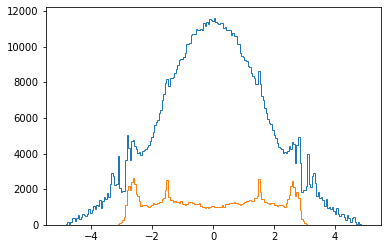

In [17]:
bins = np.linspace(-5, 5, 200)
plt.hist(baby.array("jets_eta")[baby_idx].flatten(), bins=bins, histtype="step")
#my_jet_selection = data["Jet_passes_vvv_id"]
my_jet_selection = (data["Jet_btagDeepB"] > 0.1522) & data["Jet_passes_tight_id"] & (data["Jet_pt"] > 30) & (np.abs(data["Jet_eta"]) < 999) & ~data["Jet_matches_veto_lepton"]

plt.hist(data["Jet_eta"][my_jet_selection][nano_idx].flatten(), bins=bins, histtype="step")
plt.show()

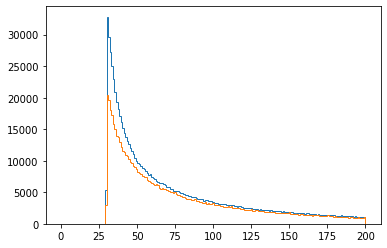

In [18]:
bins = np.linspace(0, 200, 200)
plt.hist(baby.array("jets_pt")[baby_idx].flatten(), bins=bins, histtype="step")
#my_jet_selection = data["Jet_passes_vvv_id"]
my_jet_selection = data["Jet_passes_tight_id"] & (data["Jet_pt"] > 30) & (np.abs(data["Jet_eta"]) < 2.4) & ~data["Jet_matches_veto_lepton"]

plt.hist(data["Jet_pt"][my_jet_selection][nano_idx].flatten(), bins=bins, histtype="step")
plt.show()

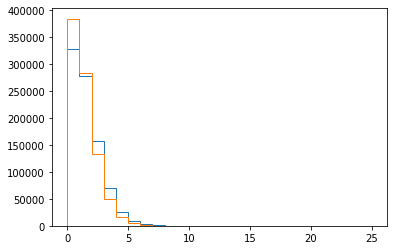

In [19]:
bins = np.linspace(0, 25, 26)
plt.hist(baby.array("jets_pt")[baby_idx].counts, bins=bins, histtype="step")
my_jet_selection = data["Jet_passes_vvv_id"]
plt.hist(my_jet_selection.sum()[nano_idx], bins=bins, histtype="step")
plt.show()

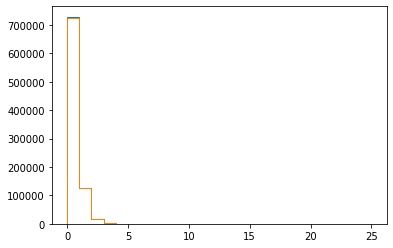

In [23]:
bins = np.linspace(0, 25, 26)
plt.hist(baby.array("nb")[baby_idx], bins=bins, histtype="step")
#my_jet_selection = (data["Jet_btagDeepB"] > 0.1522) & data["Jet_passes_tight_id"] & (data["Jet_pt"] > 20) & (np.abs(data["Jet_eta"]) < 2.4) & ~data["Jet_matches_veto_lepton"]
my_jet_selection = data["Jet_passes_vvv_b_jet_id"]
plt.hist(my_jet_selection.sum()[nano_idx], bins=bins, histtype="step")
plt.show()

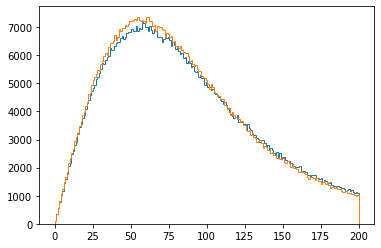

In [21]:
bins = np.linspace(0, 200, 200)
plt.hist(baby.array("met_orig_pt")[baby_idx], bins=bins, histtype="step")
plt.hist(data["MET_pt"][nano_idx], bins=bins, histtype="step")
#plt.hist(data["PuppiMET_pt"][nano_idx], bins=bins, histtype="step")
#plt.hist(data["RawMET_pt"][nano_idx], bins=bins, histtype="step")
#plt.hist(data["CaloMET_pt"][nano_idx], bins=bins, histtype="step")

plt.show()

In [22]:
for k in baby.keys():
    if b'jet' in k:
        print(k)

b'jets_p4'
b'jets_pt'
b'jets_eta'
b'jets_phi'
b'jets_mass'
b'jets_btag_score'
b'jets_cen_p4'
b'jets_cen_pt'
b'jets_cen_eta'
b'jets_cen_phi'
b'jets_cen_mass'
b'rawjets_p4'
b'rawjets_pt'
b'rawjets_eta'
b'rawjets_phi'
b'rawjets_mass'
b'rawjets_JEC'
b'rawjets_btag_score'
b'rawjets_passJetID'
b'rawjets_isORwLep'
b'J_softdropPuppiSubjet1_pt'
b'J_softdropPuppiSubjet1_eta'
b'J_softdropPuppiSubjet1_phi'
b'J_softdropPuppiSubjet1_mass'
b'J_softdropPuppiSubjet1_energy'
b'J_softdropPuppiSubjet2_pt'
b'J_softdropPuppiSubjet2_eta'
b'J_softdropPuppiSubjet2_phi'
b'J_softdropPuppiSubjet2_mass'
b'J_softdropPuppiSubjet2_energy'
